In [34]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torchvision.utils import make_grid

import torch
from torch.utils.data import random_split, DataLoader
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### **Loading the Dataset**

In [2]:
torch.manual_seed(27)

In [3]:
train_transforms = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ColorJitter(brightness=0.1,
                                                              contrast=0.1,
                                                              saturation=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                            std=[0.2023, 0.1994, 0.2010])])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                           std=[0.2023, 0.1994, 0.2010])])

In [4]:
train_dataset = CIFAR10(root='./data',
                        train=True,
                        transform=train_transforms,
                        download=False)

In [5]:
test_dataset = CIFAR10('./data',
                       train=False,
                       transform=test_transforms)

### **Separating the Dataset**

In [6]:
train_size = int(len(train_dataset) * 0.9)
val_size = int(len(train_dataset) * 0.1)

In [7]:
train_dataset, val_dataset = random_split(train_dataset, lengths=[train_size, val_size])

### **Creating the DataLoader**

In [8]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=64,
                              shuffle=True,
                              num_workers=2)

In [9]:
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=64,
                             shuffle=False,
                             num_workers=2)

In [10]:
val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=64,
                            shuffle=False,
                            num_workers=2)

### **Analysis of Class Distribution**

#### **Train**

In [11]:
train_counter = Counter()

for _, labels in train_dataloader:
    train_counter.update(labels.tolist())

In [12]:
print(f'Train labels distribution: ', sorted(train_counter.items()))

Train labels distribution:  [(0, 4497), (1, 4533), (2, 4528), (3, 4487), (4, 4470), (5, 4454), (6, 4509), (7, 4523), (8, 4511), (9, 4488)]


#### **Test**

In [13]:
test_counter = Counter()

for _, labels in test_dataloader:
    test_counter.update(labels.tolist())

In [14]:
print(f'Test labels distribution: ', sorted(test_counter.items()))

Test labels distribution:  [(0, 1000), (1, 1000), (2, 1000), (3, 1000), (4, 1000), (5, 1000), (6, 1000), (7, 1000), (8, 1000), (9, 1000)]


#### **Val**

In [15]:
val_counter = Counter()

for _, labels in val_dataloader:
    val_counter.update(labels.tolist())

In [16]:
print(f'Val labels distribution: ', sorted(val_counter.items()))

Val labels distribution:  [(0, 503), (1, 467), (2, 472), (3, 513), (4, 530), (5, 546), (6, 491), (7, 477), (8, 489), (9, 512)]


### **Viewing some Data**

In [17]:
for x, _ in train_dataloader:
    break

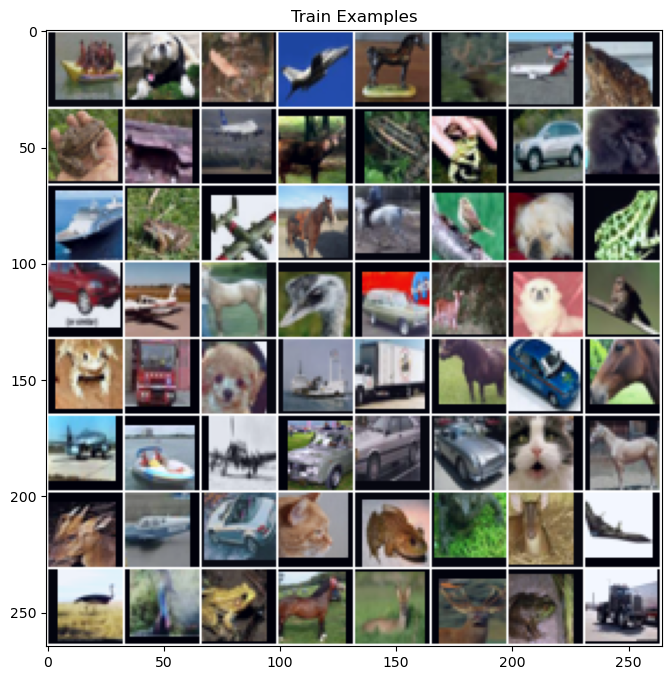

In [18]:
plt.figure(figsize=(8,8))
plt.title(f'Train Examples')
plt.imshow(np.transpose(make_grid(x[:64], 
                                  padding=1, 
                                  normalize=True, 
                                  pad_value=1.0), 
                        (1,2,0)))

### **DenseNet Architecture**

In [19]:
class DenseLayer(torch.nn.Module):

    def __init__(self, in_channels, growth_rate, drop_rate=0.0):
        super().__init__()

        self.drop_rate = drop_rate
        
        self.layers = torch.nn.Sequential(
            torch.nn.BatchNorm2d(in_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=in_channels, 
                            out_channels=4*growth_rate,  
                            kernel_size=1,
                            bias=False),

            torch.nn.BatchNorm2d(4*growth_rate),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=4*growth_rate,
                            out_channels=growth_rate,
                            kernel_size=3,
                            padding=1,
                            bias=False),
        )

        self.drop = torch.nn.Dropout2d(p=self.drop_rate)
    
    def forward(self, x):
        out = self.layers(x)

        if self.drop_rate > 0.0:
            out = self.drop(out)    

        return torch.cat([out, x], dim=1)

In [20]:
class DenseBlock(torch.nn.Module):

    def __init__(self, in_channels, n_layers, growth_rate, drop_rate=0.0):
        super().__init__()

        layers = []
        channels = in_channels

        for _ in range(n_layers):
            layers.append(DenseLayer(channels, growth_rate, drop_rate=drop_rate))
            channels += growth_rate
        
        self.dense_layers = torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.dense_layers(x)

In [21]:
class TransitionLayer(torch.nn.Module):

    def __init__(self, in_channels, theta):
        super().__init__()
        self.out_channels = int(theta * in_channels)

        self.layers = torch.nn.Sequential(
            torch.nn.BatchNorm2d(in_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=in_channels,
                            out_channels=self.out_channels,
                            kernel_size=1,
                            stride=2,
                            bias=False)
        )
    
    def forward(self, x):
        return self.layers(x)

In [22]:
class DenseNet(torch.nn.Module):

    def __init__(self, in_channels, growth_rate, theta=0.5):
        super().__init__()

        self.input_layer = torch.nn.Conv2d(in_channels=in_channels, 
                                           out_channels=growth_rate, 
                                           kernel_size=3, 
                                           padding=1,
                                           bias=False) # 32 x 32

        channels = growth_rate
        self.dense_1 = DenseBlock(in_channels=channels,
                                  n_layers=8, 
                                  growth_rate=growth_rate,
                                  drop_rate=0.2) 
        
        channels += 8 * growth_rate
        self.trans_1 = TransitionLayer(in_channels=channels, theta=theta) # 16 x 16

        channels = self.trans_1.out_channels
        self.dense_2 = DenseBlock(in_channels=channels,
                                  n_layers=16,
                                  growth_rate=growth_rate,
                                  drop_rate=0.2)
        
        channels += 16 * growth_rate
        self.trans_2 = TransitionLayer(in_channels=channels, theta=theta) # 8 x 8

        channels = self.trans_2.out_channels
        self.dense_3 = DenseBlock(in_channels=channels,
                                  n_layers=32,
                                  growth_rate=growth_rate,
                                  drop_rate=0.2)
        
        channels += 32 * growth_rate
        self.trans_3 = TransitionLayer(in_channels=channels, theta=theta) # 4 x 4

        channels = self.trans_3.out_channels
        self.dense_4 = DenseBlock(in_channels=channels,
                                  n_layers=32,
                                  growth_rate=growth_rate,
                                  drop_rate=0.2)
        
        channels += 32 * growth_rate
        self.pooling = torch.nn.AdaptiveAvgPool2d((1,1))
        self.fc = torch.nn.Linear(channels,10)
    
    def forward(self, x):
        out_1 = self.input_layer(x)
        out_2 = self.dense_1(out_1)
        out_3 = self.dense_2(self.trans_1(out_2))
        out_4 = self.dense_3(self.trans_2(out_3))
        out_5 = self.dense_4(self.trans_3(out_4))

        return self.fc(torch.flatten(self.pooling(out_5), start_dim=1))

### **Training**

In [23]:
def accuracy(model, dataloader):
    model.eval()

    acc = 0.0
    total = 0
    for x,y in dataloader:
        x = x.to('cuda')
        y = y.to('cuda')

        with torch.inference_mode():
            z = model(x)
        
        labels = torch.argmax(z, dim=1)
        labels = labels.view(y.shape).to(y.dtype)

        results = labels == y
        acc += torch.sum(results).item()
        total += torch.numel(results)
    
    return acc/total

In [25]:
epochs = 150

In [28]:
model = DenseNet(3, 12).to('cuda')
optim = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=epochs)

In [26]:
best_loss = np.inf
for epoch in range(epochs):
    model.train()

    loss_per_batch = 0.0
    num_batches = len(train_dataloader)
    for idx, (x, y) in enumerate(train_dataloader):
        x = x.to('cuda')
        y = y.to('cuda')

        z = model(x)
        loss = F.cross_entropy(z, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        loss_per_batch += loss.item()

        if idx % 50 == 0:
            print(f'Epoch: {epoch+1:03d}/{epochs} - Batch: {idx+1:03d}/{num_batches} - Loss: {loss:0.3f}')
    
    loss_per_batch /= num_batches
    scheduler.step()

    if loss_per_batch < best_loss:
        best_loss = loss_per_batch

        torch.save(model.state_dict(), 'weights.pth')
    
    print(f'Train accuracy: {accuracy(model, train_dataloader)*100:0.2f}% - Val accuracy: {accuracy(model, val_dataloader)*100:0.2f}%')

Epoch: 001/150 - Batch: 001/704 - Loss: 2.270
Epoch: 001/150 - Batch: 051/704 - Loss: 2.372
Epoch: 001/150 - Batch: 101/704 - Loss: 2.257
Epoch: 001/150 - Batch: 151/704 - Loss: 2.140
Epoch: 001/150 - Batch: 201/704 - Loss: 2.051
Epoch: 001/150 - Batch: 251/704 - Loss: 2.048
Epoch: 001/150 - Batch: 301/704 - Loss: 2.162
Epoch: 001/150 - Batch: 351/704 - Loss: 1.648
Epoch: 001/150 - Batch: 401/704 - Loss: 1.799
Epoch: 001/150 - Batch: 451/704 - Loss: 1.853
Epoch: 001/150 - Batch: 501/704 - Loss: 1.680
Epoch: 001/150 - Batch: 551/704 - Loss: 2.102
Epoch: 001/150 - Batch: 601/704 - Loss: 1.754
Epoch: 001/150 - Batch: 651/704 - Loss: 1.763
Epoch: 001/150 - Batch: 701/704 - Loss: 1.668
Train accuracy: 34.63% - Val accuracy: 34.42%
Epoch: 002/150 - Batch: 001/704 - Loss: 1.658
Epoch: 002/150 - Batch: 051/704 - Loss: 1.762
Epoch: 002/150 - Batch: 101/704 - Loss: 1.776
Epoch: 002/150 - Batch: 151/704 - Loss: 1.594
Epoch: 002/150 - Batch: 201/704 - Loss: 1.788
Epoch: 002/150 - Batch: 251/704 - 

### **Evaluating the Results**

In [29]:
model.load_state_dict(torch.load('weights.pth', map_location='cuda', weights_only=True))

<All keys matched successfully>

In [30]:
print(f'Test accuracy: {accuracy(model, test_dataloader)*100:0.2f}%')

Test accuracy: 91.40%


In [37]:
def show_confusion_matrix(model, dataloader):
    y_pred = []
    y_true = []

    model.eval()

    for x, y in dataloader:
        x = x.to('cuda')
        y = y.to('cuda')

        with torch.inference_mode():
            z = model(x)
        
        pred = torch.argmax(z, dim=1)
        pred = pred.view(y.shape).to(y.dtype)

        y_pred.extend(pred.tolist())
        y_true.extend(y.tolist())
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    plt.title('Matriz de Confusão')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

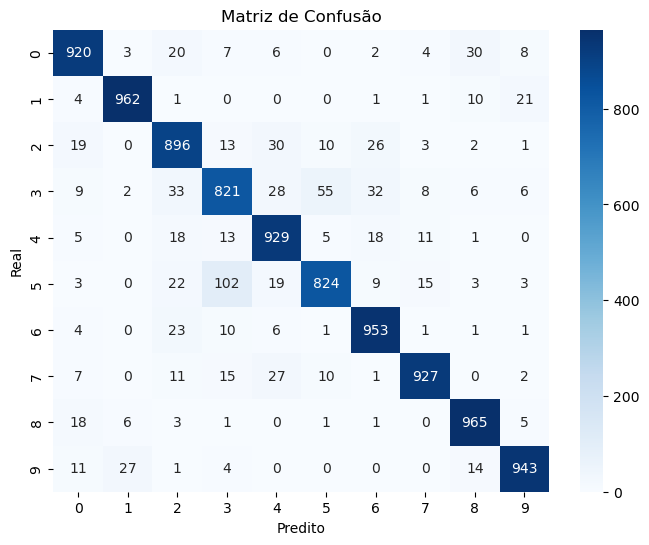

In [38]:
show_confusion_matrix(model, test_dataloader)